In [77]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

In [55]:
np.shape(X1)

(1000, 5)

In [56]:
np.shape(y1)

(1000,)

In [96]:
# generate regression dataset
data = pd.DataFrame()
X1, y1 = make_regression(n_samples=1000, n_features=5, noise=0.2, random_state=99)
X2, y2 = make_regression(n_samples=1000, n_features=5, noise=0.1,random_state=7)
d1 = np.insert(X1, 5, values=y1, axis=1)
d1 = np.insert(d1, 6, values=g1, axis=1)
d2 = np.insert(X2, 5, values=y2, axis=1)
d2 = np.insert(d2, 6, values=g2, axis=1)
data = pd.DataFrame(np.append(d1, d2, axis=0))
data = data.sample(frac=1)


In [103]:
d_bias2 = d1.copy()
for x in d_bias2:
    if(x[-1] == 0):
        if(random.random() <0.2):
            x[-2] = x[-2]*0.8
            
d_bias5 = d1.copy()
for x in d_bias5:
    if(x[-1] == 0):
        if(random.random() <0.5):
            x[-2] = x[-2]*0.8
            
d_bias7 = d1.copy()
for x in d_bias7:
    if(x[-1] == 0):
        if(random.random() <0.7):
            x[-2] = x[-2]*0.8
        

In [105]:
check = (d_bias7 == d1)[:,-2]
len(check[check==False])

682

In [108]:
data2 = pd.DataFrame(np.append(d_bias2, d2, axis=0))
data2 = data2.sample(frac=1)
data5 = pd.DataFrame(np.append(d_bias5, d2, axis=0))
data5 = data5.sample(frac=1)
data7 = pd.DataFrame(np.append(d_bias7, d2, axis=0))
data7 = data7.sample(frac=1)

In [114]:
data.sort_values(5)

,0,1,2,3,4,5,6
341,-1.897510,-1.926044,-1.511468,-2.280682,-0.545986,-542.348710,0.0
957,-1.093064,-0.590733,-2.509643,-0.140688,-1.877154,-425.660206,0.0
382,-1.787527,-2.023447,-2.398719,1.825149,-0.885930,-418.758274,0.0
822,-0.704922,-1.604984,-1.903589,-1.496792,0.008797,-411.473496,0.0
915,-0.277001,-0.802967,-1.862609,-1.642133,-1.321887,-403.267054,0.0
1813,-0.635240,-0.297400,-2.586526,-1.250573,-2.697553,-371.018205,1.0
924,-0.481563,-0.744802,-1.550093,-0.618664,-1.974976,-368.959182,0.0
223,-0.125787,-1.762705,-0.451860,-0.762435,-1.924075,-368.291127,0.0
1528,-2.381224,-0.166822,-2.682840,-1.146599,1.962715,-367.958005,1.0
250,0.477912,-2.192210,-1.079328,0.069791,-1.529821,-361.224996,0.0


In [48]:
np.shape(g)

(2000,)

In [73]:
# ax = data.plot.scatter(x='X1', y='y1', color='blue', label='Group 1');

# data.plot.scatter(x='X2', y='y2', color='red', label='Group 2', ax=ax);


In [ ]:
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

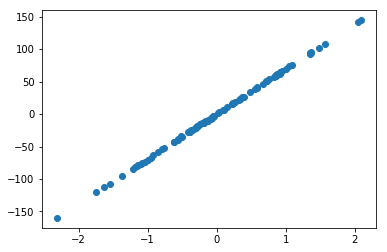

In [76]:
# generate regression dataset
X, y = make_regression(n_samples=100, n_features=1, noise=0.9)
# plot regression dataset
plt.scatter(X,y)
plt.scatter()